# Analyzing the Influenza data via ARIMA for short term projections

In [1]:
from IPython.display import Javascript

### Mount data location

In [2]:
import os

os.chdir('.') ## for local

### Install python and R packages (installing R packages can be slow)

In [3]:
#%%capture
%reload_ext rpy2.ipython

%R needed.packages <- c('easypackages','tidyverse','lubridate','cowplot','colorspace','MLmetrics','imputeTS', 'broom', 'janitor', 'magrittr', 'kableExtra')
%R new.packages <- needed.packages[!(needed.packages %in% installed.packages()[,"Package"])]
%R if(length(new.packages)) install.packages(new.packages)

%R suppressPackageStartupMessages(library(easypackages))
%R suppressPackageStartupMessages(libraries(needed.packages))

R[write to console]: All packages loaded successfully



In [4]:
#%%capture
import time

## Data manipulation tools
import numpy as np
import pandas as pd
import pmdarima

## Time series analysis libraries sktime
from sktime.forecasting.compose            import ForecastingPipeline, TransformedTargetForecaster
from sktime.forecasting.compose            import AutoEnsembleForecaster
from sktime.transformations.compose        import TransformerPipeline
from sktime.transformations.series.compose import OptionalPassthrough
from sktime.forecasting.compose            import make_reduction
from sktime.forecasting.base               import ForecastingHorizon
from sktime.transformations.series.adapt   import TabularToSeriesAdaptor
from sktime.transformations.series.impute  import Imputer

from sktime.forecasting.model_selection    import ExpandingWindowSplitter
from sktime.forecasting.model_selection    import ForecastingGridSearchCV
from sktime.forecasting.model_selection    import temporal_train_test_split

from sklearn.preprocessing                 import MinMaxScaler, StandardScaler, RobustScaler, PowerTransformer
from sklearn.neighbors                     import KNeighborsRegressor
from sklearn.linear_model                  import ElasticNet

from sktime.forecasting.naive              import NaiveForecaster
from sktime.forecasting.ets                import AutoETS
from sktime.forecasting.arima              import AutoARIMA

## accessories
import pickle
import rpy2.robjects as ro

### R Functions

In [5]:
%%R

cols <- c("#396AB1", "#DA7C30", '#3E9651', '#CC2529')

plot_basic_timeseries <- function(ldf) {
  ggplot(ldf %>% pivot_longer(!date, names_to = 'region', values_to = 'incidence'), 
         aes(x = date, 
             y = incidence)) +
  geom_point(color = '#000000',
             fill = '#AAAAAA',
             shape = 21,
             size = 3) +
  geom_line(size = 1.05,
            alpha = 0.5) +
  facet_wrap(~region, ncol = 3, scales = 'free_y') +
  xlab('date') +
  ylab('Flu incidence') +
  theme_bw(24)
}

### Python Functions

In [6]:
def generate_predictions_for_region(lgs, ldata, lseries, lnt, n_ahead):
  lpred = []
  lreal = []
  lnaive = []
  lmodels = []
  fh = np.array([n_ahead])

  print(lseries)

  ltrain, ltest = make_data(ldata, lnt)

  lfit = lgs.fit(ltrain[[lseries]].dropna(), fh = fh)
  lmodels.append(lfit)

  print(lfit)

  for i in range(len(ldata[[lseries]]) - lnt):
    ltrain, ltest = make_data(ldata, lnt + i)
    lfit = lfit.fit(ltrain[[lseries]].dropna(), fh = fh)
    lpred.append(np.array(lfit.predict(fh)).flatten()[0])
    lnaive.append(ltrain[[lseries]].dropna().values.flatten()[-1])

    if len(ltest[[lseries]].values.flatten()) >= n_ahead:
      lreal.append(ltest[[lseries]].values.flatten()[n_ahead - 1])
    else:
      lreal.append(np.NAN)

  lfit = lfit.fit(make_data(ldata, len(ldata[[lseries]].dropna()))[[lseries]], fh = fh)
  lpred.append(np.array(lfit.predict(fh)).flatten()[0])
  lreal.append(np.NAN)
  lnaive.append(make_data(ldata, len(ldata[[lseries]]))[[lseries]].values.flatten()[-1])

  return lpred, lreal, lnaive, lmodels

def generate_predictions_for_country(lgscv, ldata, lnt, n_ahead):
  fdf = pd.DataFrame()

  for tseries in ldata.columns[1:]:
    l_pred, l_real, l_naive, lmodels = generate_predictions_for_region(lgscv, ldata, tseries, lnt, n_ahead)
    
    l_dates = [(pd.to_datetime(ldata.date.values[-1]) + pd.DateOffset(weeks = i + 1)).strftime('%Y-%m-%d') for i in range(n_ahead)]
    lpred_df = pd.DataFrame({'date': np.append(ldata.iloc[(lnt + n_ahead - 1):,].date.values, l_dates),
                             'Model': l_pred,
                             'Real': l_real,
                             'Persistence': l_naive,
                             'horizon': np.repeat(n_ahead, len(l_pred)),
                             'dev': np.repeat(tseries, len(l_pred))})
    
    fdf = pd.concat([fdf, lpred_df])
  
  return fdf, lmodels

def make_data(ldata, lnt):
  opt_df = ldata.set_index('date')
  opt_df.index = pd.to_datetime(opt_df.index)
  opt_df.index = pd.PeriodIndex(opt_df.index, freq = "D")
  
  if lnt == ldata.shape[0]:
    return opt_df
  else:
    ltrain, ltest = temporal_train_test_split(opt_df, train_size = lnt)
    return ltrain, ltest

### Grab the data

In [7]:
%%R

idata <- read_csv('../imputed_and_stitched_hosp.csv') %>%
  filter(location_name != 'Florida' &
           location_name != 'Puerto Rico' &
           location_name != 'Virgin Islands') %>%
  mutate(value = total_hosp) %>%
  dplyr::select(date, location_name, value) %>%
  pivot_wider(names_from = location_name, values_from = value) %>%
  drop_na() %>%
  mutate(date = as.character(date))

#data <- idata[217:nrow(idata),]
data <- idata

print(data, n = 10)

Rows: 31779 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_name
dbl  (5): ili, pred_hosp, true_hosp, population, total_hosp
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
# A tibble: 604 × 52
   date       Alabama Alaska Arizona Arkansas California Colorado Connecticut
   <chr>        <dbl>  <dbl>   <dbl>    <dbl>      <dbl>    <dbl>       <dbl>
 1 2012-10-06      30      2       0        2        204       15           0
 2 2012-10-13      28      4       0        2        279       12           0
 3 2012-10-20      25      0       3        0        310       25           0
 4 2012-10-27      32      3       0        0        188       30           0
 5 2012-11-03      46      1      21       11        420       34           0
 6 2012-11-10      59      3       2       14        502    

### Basic Time Series

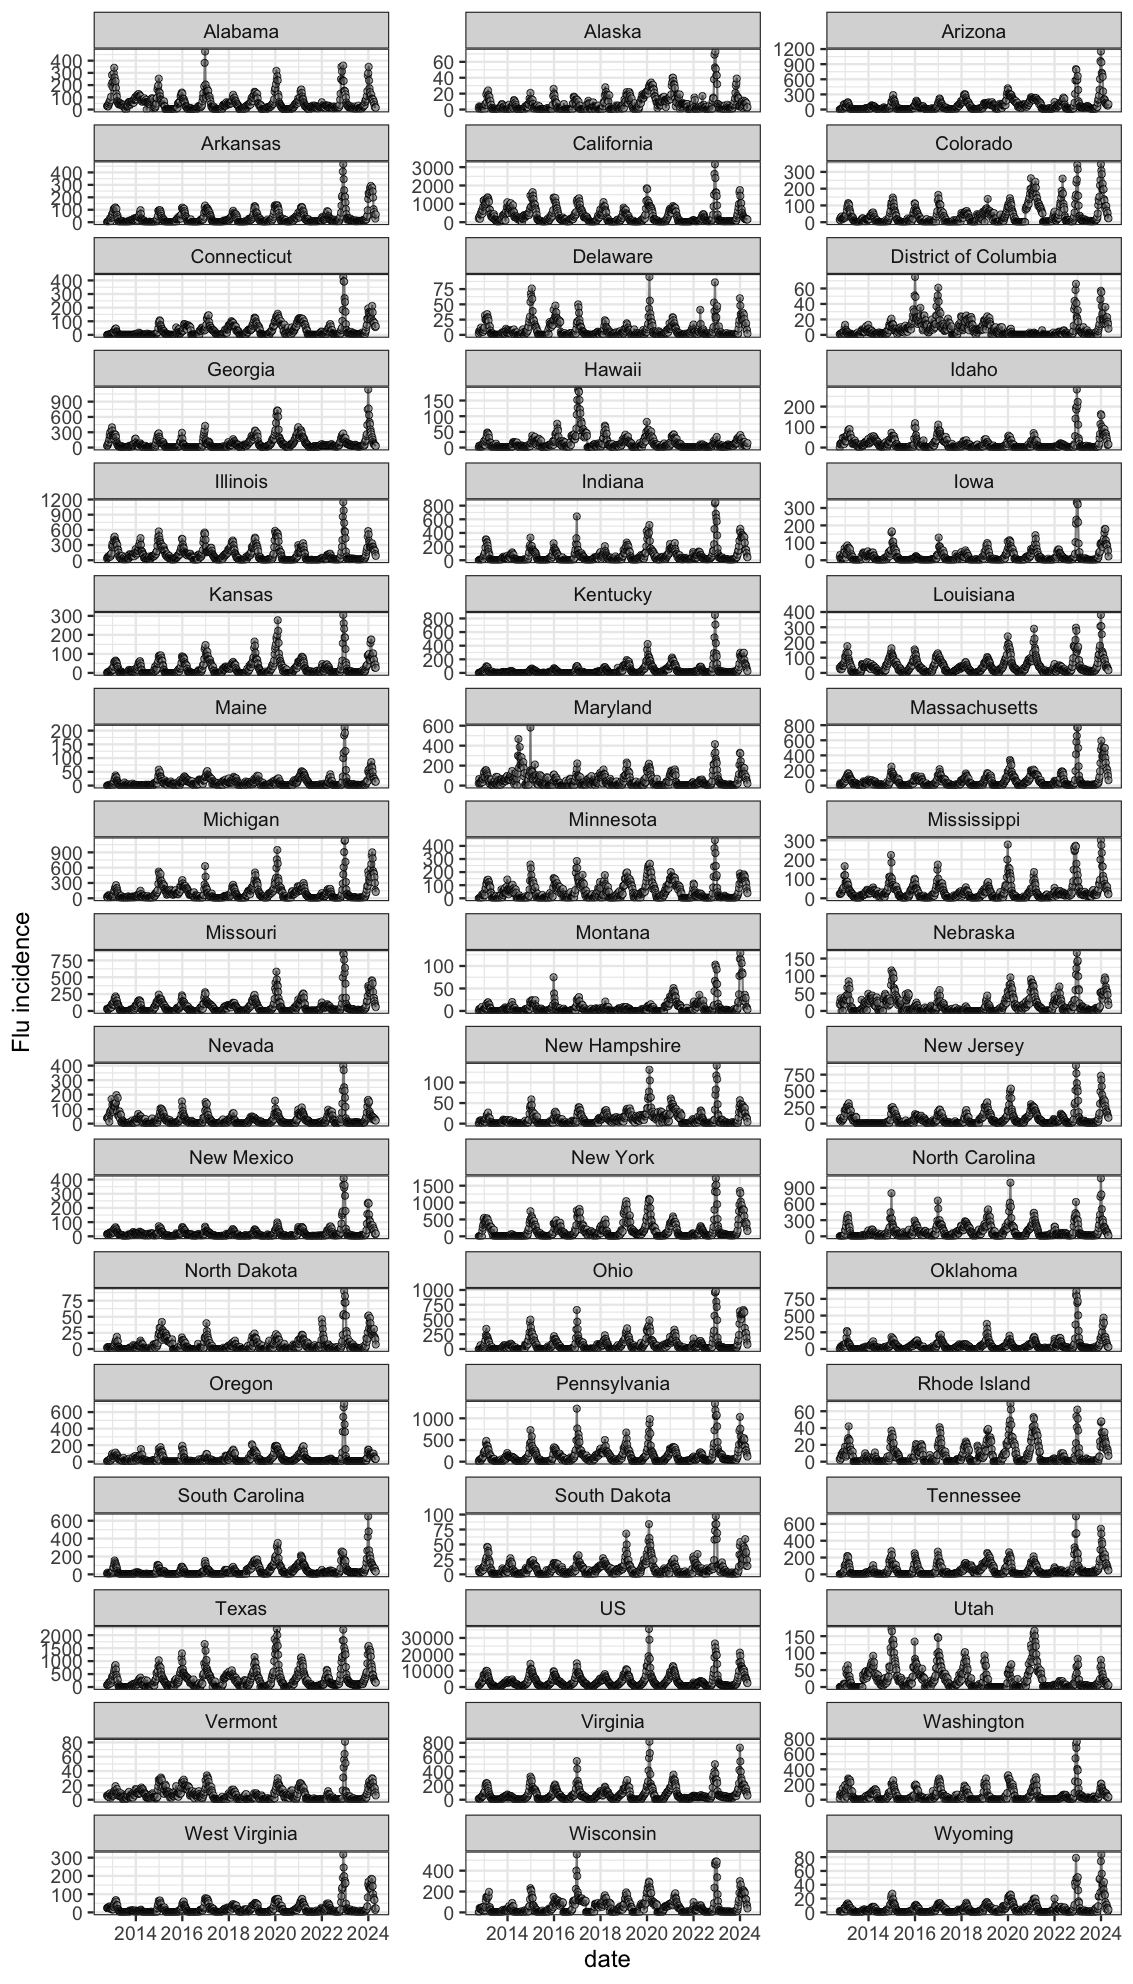

In [8]:
%%R -w 40 -h 70 -u cm

data$date <- ymd(data$date)

p.basic <- plot_basic_timeseries(data)
show(p.basic)

### Send to Python

In [9]:
%R data$date <- as.character(data$date)
%R -o data

### Create train and test split

In [10]:
num_train = 587

extrain, extest = make_data(data, num_train)
display(extest)

,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Georgia,...,Tennessee,Texas,US,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2024-01-06,350.0,5.0,935.0,234.0,1420.0,308.0,167.0,48.0,55.0,765.0,...,482.0,1589.0,18936.0,63.0,15.0,538.0,209.0,169.0,248.0,84.0
2024-01-13,237.0,6.0,728.0,223.0,1030.0,286.0,159.0,34.0,37.0,635.0,...,394.0,1391.0,15291.0,47.0,24.0,393.0,161.0,136.0,267.0,56.0
2024-01-20,173.0,9.0,700.0,227.0,1042.0,197.0,128.0,32.0,27.0,500.0,...,361.0,1292.0,12801.0,28.0,26.0,305.0,145.0,145.0,176.0,23.0
2024-01-27,143.0,7.0,649.0,276.0,706.0,229.0,156.0,28.0,21.0,459.0,...,280.0,1435.0,12447.0,38.0,21.0,270.0,120.0,136.0,141.0,40.0
2024-02-03,103.0,8.0,360.0,245.0,517.0,196.0,111.0,25.0,20.0,354.0,...,223.0,1350.0,11317.0,28.0,18.0,190.0,105.0,127.0,175.0,40.0
2024-02-10,112.0,11.0,188.0,292.0,411.0,196.0,142.0,25.0,14.0,308.0,...,197.0,1176.0,11018.0,16.0,20.0,179.0,80.0,131.0,178.0,33.0
2024-02-17,122.0,2.0,204.0,258.0,328.0,137.0,119.0,36.0,19.0,259.0,...,195.0,892.0,10767.0,19.0,21.0,202.0,73.0,184.0,209.0,44.0
2024-02-24,89.0,4.0,204.0,275.0,300.0,129.0,173.0,24.0,18.0,188.0,...,203.0,788.0,10454.0,9.0,26.0,208.0,99.0,163.0,213.0,27.0
2024-03-02,85.0,11.0,182.0,278.0,269.0,93.0,213.0,33.0,15.0,202.0,...,237.0,655.0,10500.0,17.0,30.0,215.0,76.0,181.0,200.0,25.0


## We'll start with predicting

### Construct a pipeline with transformation followed by predictions


In [11]:
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore::UserWarning"
    os.environ["PYTHONWARNINGS"] = "ignore::FutureWarning"
np.warnings = warnings

horizon = 4

sspipe = TransformerPipeline(steps = [TabularToSeriesAdaptor(PowerTransformer())])

arma_forecaster = AutoARIMA(sp = 1, suppress_warnings = True, error_action = "ignore", n_jobs = -1)

pipe = TransformedTargetForecaster(steps=[("preprocessor", sspipe),
                                          ("forecaster", arma_forecaster)])

all_horizons = pd.DataFrame()
all_models = []
for i in range(horizon): 
    country_predictions, models = generate_predictions_for_country(pipe, data, num_train, i + 1)
    all_horizons = pd.concat([all_horizons, country_predictions])
    all_models.append(models)

Alabama
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',
                                    AutoARIMA(error_action='ignore', n_jobs=-1,
                                              suppress_warnings=True))])
Alaska
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',
                                    AutoARIMA(error_action='ignore', n_jobs=-1,
                                              suppress_warnings=True))])
Arizona
TransformedTargetForecaster(steps=[('preprocessor',
                                    TransformerPipeline(steps=[TabularToSeriesAdaptor(transformer=PowerTransformer())])),
                                   ('forecaster',

In [12]:
all_horizons

,date,Model,Real,Persistence,horizon,dev
0,2024-01-06,284.340840,350.0,298.0,1,Alabama
1,2024-01-13,327.343647,237.0,350.0,1,Alabama
2,2024-01-20,234.379701,173.0,237.0,1,Alabama
3,2024-01-27,165.504160,143.0,173.0,1,Alabama
4,2024-02-03,130.655544,103.0,143.0,1,Alabama
...,...,...,...,...,...,...
13,2024-04-27,6.474348,4.0,11.0,4,Wyoming
14,2024-05-04,5.510002,NaN,7.0,4,Wyoming
15,2024-05-11,4.850945,NaN,6.0,4,Wyoming
16,2024-05-18,2.562913,NaN,2.0,4,Wyoming


### Push data over to R

In [13]:
%%capture
%R -i all_horizons

### Quick Error Check

In [14]:
%%R

all_horizons %>%
  drop_na() %>%
  filter(horizon == 1) %>%
  summarise(model = RMSE(Model, Real), 
            naive = RMSE(Persistence, Real))

     model   naive
1 178.9283 210.671


In [15]:
%%R

all_horizons %>%
  drop_na() %>%
  filter(horizon == 1) %>%
  group_by(dev) %>%
  summarise(model = RMSE(Model, Real), 
            naive = RMSE(Persistence, Real))

# A tibble: 51 × 3
   dev                   model  naive
   <chr>                 <dbl>  <dbl>
 1 Alabama               34.0   38.2 
 2 Alaska                 3.35   3.87
 3 Arizona              163.   112.  
 4 Arkansas              40.4   37.5 
 5 California           160.   160.  
 6 Colorado              34.0   33.7 
 7 Connecticut           36.2   32.7 
 8 Delaware               8.25   7.78
 9 District of Columbia   9.07   9.72
10 Georgia              109.   109.  
# ℹ 41 more rows
# ℹ Use `print(n = ...)` to see more rows


In [16]:
%%R

tmp <- read_csv('../imputed_and_stitched_hosp.csv') %>%
  arrange(date)

sarima.r <- all_horizons %>%
  mutate(value = Model,
         date_predicted = date,
         location_name = dev,
         target_value = Real) %>%
  select(date_predicted, value, target_value, location_name, horizon) %>%
  mutate(date_created = Sys.Date(),
         aggregation = 'weekly', 
         model = 'sarima', 
         target = 'cases') %>%
  relocate(any_of(c("date_created", "date_predicted", 
                    "aggregation", 'location_name',
                    'model', 'target', 'horizon', 'value', 'target_value')))

write_csv(sarima.r, file = 'flu_sarima_predictions.csv')

Rows: 31779 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (1): location_name
dbl  (5): ili, pred_hosp, true_hosp, population, total_hosp
date (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
